# DSAN 5650 HW1: Probabilistic Graphical Models of Data-Generating Processes

**Assignment Corrections (Run Following Cell to Fetch)**

In [123]:
%run fetch_corrections.py

**DSAN5650 HW1 Corrections:**

[Jun 5, 11:30pm]

* **Q2.4:** The "Observation" portion should say "we observe **all 5 students** back at the starting position $x = 0$." (rather than "all 3 students")
* **Q2.4:** The trajectory given for **bouncing right** should be $(0, 1, 2, 1, 0)$, and for **bouncing left** should be $(0, -1, -2, -1, 0)$
* **Q3.1:** To be a bit more clear, option (a) should read "**Up-to-date** data on the county-wide average number of cigarettes smoked per county resident **each** day [rather than "per day"], for each county in the USA"
* **Q4.2a:** The last line (after the "Once the PGM is constructed" comment) should be `gnb.showInference(super_party_net)`, rather than just `display(super_party_net)` (since the next part asks you to "use this visualization to answer the following question", and the answer requires the prior probability tables!)


Last fetched: 2025-06-06 06:56:04 EDT

**Assignment Submission (Run Following Cell to Generate Submit Button)**

In [124]:
%run submit_button.py

Button(description='Submit HW1', style=ButtonStyle())

Output()

Welcome to the first homework assignment for *DSAN 5650: Causal Inference for Computational Social Science*! As Jeff [lamented](https://into-prodweb.s3.amazonaws.com/uploads/2024/09/sad-ant-with-bindle.jpg) at the beginning of Week 2, this assignment was delayed due to my brain's back-and-forth teetering between which languages/libraries would be "best" for learning 😭

But, I hope the payoff from all that is a "gentle introduction" to PGMs which serves as a **stepping stone** towards the full richness of probabilistic modeling for causal computational social science that we'll do in later weeks. To this end, my key goals for you in this assignment are that:

1. By the end you'll be slightly less scared of the little circles-and-arrows pictures provided for each model in the [`doubleml`](https://docs.doubleml.org/stable/guide/models.html) library, which we'll use later on in the course!
2. You'll become more and more comfortable "converting" your intuitions around causality into explicit, rigorous, well-defined probabilistic models, by way of the [`pyagrum`](https://pyagrum.readthedocs.io/en/2.1.1/index.html) library (taking care to not get too attached to `pyagrum` since this is precisely the "stepping stone" I mentioned above: from HW2 onwards, we'll move away from `pyagrum` as a "lite" Probabilistic Programming Language and towards full-fledged [`PyMC` modeling](https://www.pymc.io/welcome.html))

# [Part 1] Apples-to-Apples Comparisons

## The Causal Social-Scientific Question

In this part, the specific social phenomenon we are interested in is as follows:

> * **What causal effect does attending a *private* university have on *future earnings*,**
> * **relative to the *counterfactual* of attending a *public* university?**

To answer it, if we had infinite time, we'd dive into a famous paper: Dale and Kruger (1999), ["Estimating the Payoff to Attending a More Selective College: An Application of Selection on Observables and Unobservables"](https://www.nber.org/papers/w7322)

## The Methodological Significance

However, since we don't have infinite time, we instead use a toy dataset (meant to simulate the kinds of correlational vs. causal issues which arise in the *real* dataset which resulted from the above-cited paper: the [NCES Baccalaureate & Beyond](https://nces.ed.gov/surveys/b&b/) panel study). The real point of putting this first and foremost on HW1 is to give you a first taste for **how drastically our estimates of some effect we care about can differ** between:

* (a) An **apples-to-oranges** 🙅 approach, where we just ham-fistedly subtract the overall-average future earnings of *public school* students from the overall-average future earnings of *private school* student, and
* (b) An **apples-to-apples** 🙆 approach, where we
    * Explicitly think about (and then model) how to **match** students who are as **similar** as possible in all respects besides the public-private status of the institution they ended up attending,
    * Compute private-public differences only ***within* clusters of comparable (minimally-similar) students**, then
    * Aggregate these cluster-specific differences into an overall estimate of the difference via **weighted sum** (where the weight assigned to each cluster is just the number of observations in the cluster)

## Social Significance / Policy Implications

After you see how different the two estimates resulting from these approaches can be, you should then "zoom out" and think about the broader social relevance (and relevance for public policy):

> * Important **real-world decisions** that people make in their lives, such as whether and where to go to **college**, can hinge on their understanding of the return from private relative to public education, and...
> * Because the differences can be so large, reporting the **apples-to-oranges** estimate may convince them that private school is "worth it", whereas reporting the **apples-to-apples** estimate may instead convince them of the opposite!

I hope, therefore, you can come away with the perspective that the causal tools we're learning, such as matching estimators, are more than just "tweaks" to existing methods like regression: they can produce **substantially different results** with **fundamentally divergent policy implications**.

And, given that e.g. the [US executive branch](https://www.whitehouse.gov/cea/) and the [European Union](https://scientificadvice.eu/about-us/group-of-chief-scientific-advisors/about-the-advisors/) both have entire councils of social scientists providing policy advice, it becomes even more important to know how the apples-to-oranges approach easily falls prey to e.g. conflating the component of future-earnings differences due to **background socioeconomic status** (or any other confounding variable) with the component due to **private vs. public education** (the stated independent variable in the model).

To begin, run the following code cell to load the data for this question into a Pandas `DataFrame`.

In [93]:
%config IPCompleter.use_jedi=False

In [142]:
import pandas as pd
import numpy as np
data_url = "https://raw.githubusercontent.com/jpowerj/dsan-content/refs/heads/main/2025-sum-dsan5650/hw1/college_matching.csv"
college_df = pd.read_csv(data_url)
college_df

,student_id,school,school_type,admitted,enrolled,earnings_1996
0,4,Weasel Institute of Technology,Private,True,True,60000
1,4,College of Western Olingo,Public,True,False,60000
2,3,Capybara A&M,Public,True,True,110000
3,9,Otter State University,Public,True,False,60000
4,2,Skunkington University in Saint Louis,Private,True,True,100000
5,3,Mouse University in the City of New York,Private,False,False,110000
6,1,Capybara A&M,Public,True,False,110000
7,8,Capybara A&M,Public,True,False,90000
8,7,Mouse University in the City of New York,Private,True,True,75000
9,5,Otter State University,Public,True,False,30000


Note how the **unit of observation** is a bit weird here: it's not **students** (since some of the students, labeled by `student_id`, appear multiple times), but it's not **schools** either (since some of the schools also appear multiple times).

The unit of analysis is **student-school pair**: each row represents a student's **application** to a school, with the columns representing attributes of this application:

* `school_type`: Contains the string value `"Public"` for public schools, and `"Private"` for private schools
* `admitted`: Contains the boolean value `True` if the student's application was successful (they received an offer of admission from the school)
* `enrolled`: Contains the boolean value `True` if the student then went on to **enroll** at the school (they accepted the offer of admission), and `False` if the student (a) was accepted but didn't enroll or (b) was not accepted
* `earnings_1996`: The "future earnings" (since this was a simulation of real data, as mentioned above, from a longitudinal study conducted starting in the 1980s) of the student, in terms of yearly income, after attending and graduating from the school indicated by `enrolled` (students who did not end up graduating are not included in this particular sample).

## [Question 1.1] The "Raw" Effect Estimator

Your task in this question is to create a single reusable **function** (as opposed to just code in a cell to be run once time) for what Pearl and Mackenzie (2018) would call the **estimator** for the **estimand** of interest, namely, the difference in future earnings between private and public school attendees.

Your function will then be used **twice** in the remainder of this part:

* The first time, in Question 1.2, you'll use it to compute the apples-to-oranges estimate, averaging over the entire dataset without regard to how similar or dissimilar the applicants are.
* Then, in Question 1.4, you'll use it again (multiple times now) to compute the difference **within** each similarity-based cluster of applicants.

I mention these two uses because, part of your task will be to make sure that your function is **general enough** to work in both cases: that is, it should **not** compute the difference for `college_df` specifically. Rather, it should take an **arbitrary Pandas `DataFrame`, named `df`, as an argument**, and should **return** the private-minus-public estimate for **whatever** `df` is passed to it.

Starter code is provided for you in the following cell, with comments indicating what you should fill in.

In [143]:
# @title Q1.1a-response
def compute_diff(df):
    # Step 1: Create a new DataFrame called enrolled_df, containing *only* the
    # rows in college_df where the student ended up enrolling in the school

    enrolled_df = df[df['enrolled']==True] # Your code here (replace the None)
    
    # Step 2: Compute mean earnings for students who enrolled in *private* schools
    
    private_mean = enrolled_df['earnings_1996'][enrolled_df['school_type'] == 'Private'].mean() # Your code here (replace the None)
    
    # Step 3: Compute mean earnings for students who enrolled in *public* schools
    
    public_mean = enrolled_df['earnings_1996'][enrolled_df['school_type'] == 'Public'].mean() # Your code here (replace the None)
    
    # Step 4: Compute the *difference* between these two means
    # (the mean earnings for students who enrolled in private schools minus the
    # mean earnings for students who enrolled in public schools)

    mean_diff = private_mean - public_mean # Your code here (replace the None)

    # Step 5: Return the computed difference (this step is done for you!)
    
    return mean_diff


In [144]:
# @title Q1.1a-public-tests
assert 'compute_diff' in globals(), "🔲 No function named 'compute_diff' exists in Python memory"

Now, use the `compute_diff()` function you implemented above to compute the **apples-to-oranges** estimate of the difference in future earnings between private and public school attendees, storing the result in a variable named `raw_diff` and then printing out its value.

In [145]:
# @title Q1.1b-response
raw_diff = compute_diff(college_df)  # Your code here (replace the None)
print(raw_diff)

19500.0


In [146]:
# @title Q1.1b-public-tests
assert 'raw_diff' in globals(), "🔲 No variable named 'raw_diff' exists in Python memory"
assert 'raw_diff' in globals() and raw_diff is not None, "🔲 value of 'raw_diff' should not be None"

You should obtain an estimate that the increased return from **private school** attendance relative to **public school** attendance is **\$19,500 per year**... perhaps an amount this high makes it worth it? Especially considering that, [accounting for inflation](https://www.bls.gov/data/inflation_calculator.htm), this is equivalent to **$40,514.91** today 😱

## [Question 1.2] Defining and Implementing our Similarity Measure

Now, as mentioned earlier, one of the key points early on in this class is to be **skeptical** about the veracity of the estimate you just computed. For... a bunch of sociological reasons<sup>[1]</sup>, it is likely that the "raw" estimate is an *overestimate*, since it fails to account for the **selection bias** which exists **prior to** the recording of the data itself:

* What was the *process* (the DGP!) behind certain students deciding to apply to certain schools in the first place? * And, once the decisions were mailed back to these students, what was the *process* behind their ultimate enrollment choices?

The following example from Angrist and Pischke (2014), of an applicant named Uma who ended up going to U-Mass and an applicant named Harvey who ended up going to Harvard, though both were accepted to both schools:

> *Consider again the tale of Uma and Harvey: both applied to, and were admitted to, U-Mass and Harvard. The fact that Uma applied to Harvard suggests she has the motivation to go there, while her admission to Harvard suggests she has the ability to succeed there, just like Harvey. (At least that's what the Harvard admissions office thinks). Uma nevertheless opts for a cheaper U-Mass education. Her choice might be attributable to factors that are not closely related to Uma’s earnings potential, such as a successful uncle who went to U-Mass, a best friend who chose U-Mass, or the fact that Uma missed the deadline for that easily won Rotary Club scholarship that would have funded an Ivy League education. If such serendipitous events were decisive for Uma and Harvey, then the two of them make a good match.* (Angrist and Pischke 2014, pp. 51-52)

To move towards the **apples-to-apples estimate**, then, we'll first need a **similarity measure** which quantifies how "reasonable" we think it is to compare two applicants' future earnings---quantifying whether they're a "good match" like Uma and Harvey. In a few weeks, we'll dive more deeply into the notion of how to define when observations are "similar enough" to be considered comparable (this is precisely what **propensity score-based matching** is designed to tackle), but for this week we'll simply have a binary 0-1 similarity measure:

Given a pair of students $i$ and $j$

* Students who **applied to the same set of schools** and received the **exact same decisions** from these schools will be considered **comparable** ($\textsf{Similarity}(i,j) = 1$). For example:
    * If $i$'s outcome profile is (Accepted to Mouse University) and $j$'s outcome profile is (Accepted to Mouse University), $i$ and $j$ are **comparable**
* Otherwise, students will be considered **not comparable** ($\textsf{Similarity}(i,j) = 0$). For example:
    * If $i$'s outcome profile is (Accepted to Otter State, Not Accepted to Capybara A&M) but $j$'s is (Accepted to Otter State, Accepted to Capybara A&M), $i$ and $j$ are **not comparable**, since they have different `admitted` outcomes from Capybara A&M
    * If $i$'s outcome profile is (Accepted to Otter State) but $j$'s is (Accepted to Otter State, Accepted to Capybara A&M), $i$ and $j$ are also **not comparable**, since the sets of schools they applied to are not identical.

The following code cell should be helpful for getting started on this task: it uses Pandas' `pivot()` function to construct a **grid** wherein each row represents a student $x$ (so, note that the **unit of observation** has now changed to **student**), each column represents a school $y$, and the value in each cell is:

* The float value `NaN` (though you should use `np.nan` to reference this value in your code!) if student $x$ did not apply to school $y$
* The boolean value `False` if student $x$ applied but was not admitted to school $y$
* The boolean value `True` if student $x$ applied and was admitted to school $y$

---

<small>

1.  If you took DSAN 5450, you know all about these reasons! If not, the ultra-fast summary is that there are both [*descriptive*](https://plato.stanford.edu/entries/decision-theory-descriptive/) and *normative* (ethical) justifications for this skepticism.

    The descriptive issue is simply that it doesn't accurately measure the effect we are studying: we want to capture $\beta$ but we end up capturing some biased quantity $\beta + \varepsilon$. Textbooks on quantitative methods typically have big sections or whole chapters describing steps that can be taken to "correct for" these biases quantitatively.

    The normative issue comes into play when we "add in" the ethical implications of this descriptive inaccuracy: for example that $\varepsilon$ may not be "random" (i.e., in this case, not normally-distributed with mean 0), but may in fact skew in a particular *direction* which favors some social groups or some policies over others. See [this talk](https://www.youtube.com/watch?v=8qMC1fZJMi4) by amazing researcher Lily Hu (whose research is all about ["causal theorizing about the social world"](https://www.lilyhu.org/)), for an example of how even "controlling for" things in an effort to correct descriptive biases may not resolve the normative implications.

</small>

In [147]:
# @title Q1.2-grid
app_df = college_df.pivot(columns="school", index="student_id", values="admitted")
app_df.columns.name = None
app_df

,Capybara A&M,College of Western Olingo,Mouse University in the City of New York,Otter State University,Skunkington University in Saint Louis,Weasel Institute of Technology
student_id,,,,,,
1,True,NaN,False,NaN,True,NaN
2,True,NaN,False,NaN,True,NaN
3,True,NaN,False,NaN,True,NaN
4,NaN,True,NaN,True,NaN,True
5,NaN,True,NaN,True,NaN,True
6,NaN,NaN,True,NaN,NaN,NaN
7,NaN,NaN,True,NaN,NaN,NaN
8,True,NaN,NaN,True,NaN,False
9,True,NaN,NaN,True,NaN,False


Now, in the following code cell, your task is to **use this grid** (stored as `app_df`) to construct an **"application profile string"** for each student. This may seem vague or confusing at first, but it turns out to be fairly crucial for understanding matching estimators! The format that this string should have is as follows:

1. First, the schools should be **sorted alphabetically by name** (note how the columns in the above helper code cell are already in this order, moving left-to-right). Each slot in the eventual profile string corresponds to one school, so that the first character will represent Capybara A&M, the second College of Western Olingo, and so on.
2. Once you've ensured that the schools are sorted by name, use the following scheme to encode the three different possible states:
   * `0` to represent (student, college) pairs where the student did not apply to the college
   * `1` to represent (student, college) pairs where the student applied but was not admitted to the college
   * `2` to represent (student, college) pairs where the student applied and was admitted to the college
3. Finally, each student's profile string is just the **concatenation** of this collection of `0`s, `1`s, and `2`s.

So, for example, if a student only applied to Capybara A&M and Weasel Institute of Technology, and was accepted to Capybara but rejected by Weasel, their profile string would be: **`200001`**

In the following code cell we've provided one more piece of starter code, which constructs `enrolled_df` as the subset of `college_df` representing the eventual enrollment decisions for each student (so that, again, the unit of observation in `enrolled_df` is **student**).

Your task is to use `app_df` to construct the profile strings for each student, then **merge** these constructed strings back into `enrolled_df`, so that we end up with a version of `enrolled_df` that has:

* The **independent variable** `school_type`,
* The **dependent variable** `earnings_1996`, and
* A summary of the **possible confounding variables**, `profile_string`

In [148]:
# @title Q1.2-helper
enrolled_df = college_df[college_df['enrolled']].copy()
enrolled_df

,student_id,school,school_type,admitted,enrolled,earnings_1996
0,4,Weasel Institute of Technology,Private,True,True,60000
2,3,Capybara A&M,Public,True,True,110000
4,2,Skunkington University in Saint Louis,Private,True,True,100000
8,7,Mouse University in the City of New York,Private,True,True,75000
14,5,College of Western Olingo,Public,True,True,30000
15,1,Skunkington University in Saint Louis,Private,True,True,110000
17,8,Otter State University,Public,True,True,90000
18,9,Capybara A&M,Public,True,True,60000
21,6,Mouse University in the City of New York,Private,True,True,115000


In [149]:
# @title Q1.2-response
transformed_df = app_df.map(lambda x: '0' if pd.isna(x)  else '1'  if x is False else '2')
profile_string = pd.DataFrame(transformed_df.apply(''.join, axis=1)).reset_index()
profile_string.columns = ['student_id', 'profile_string']
enrolled_df = enrolled_df.merge(profile_string, on='student_id' , how='left')
# Your code here: build profile strings using app_df, then merge them into
# enrolled_df so it has an additional column named profile_string

In [150]:
enrolled_df

,student_id,school,school_type,admitted,enrolled,earnings_1996,profile_string
0,4,Weasel Institute of Technology,Private,True,True,60000,020202
1,3,Capybara A&M,Public,True,True,110000,201020
2,2,Skunkington University in Saint Louis,Private,True,True,100000,201020
3,7,Mouse University in the City of New York,Private,True,True,75000,002000
4,5,College of Western Olingo,Public,True,True,30000,020202
5,1,Skunkington University in Saint Louis,Private,True,True,110000,201020
6,8,Otter State University,Public,True,True,90000,200201
7,9,Capybara A&M,Public,True,True,60000,200201
8,6,Mouse University in the City of New York,Private,True,True,115000,002000


## [Question 1.3] The Unweighted Matching Estimator (Don't Use This IRL)

Now that you've done the hard work of explicitly defining those **profile strings**, which **uniquely identify** each group that you believe to be comparable (under the assumptions of our model), computation of the matching estimates becomes easy, and better captures the true causal effect we're after! Citing Angrist and Pischke (2014) again:

> *Within each group, students are likely to have similar career ambitions, while they were also judged to be of similar ability by admissions staff at the schools to which they applied. Within-group comparisons should therefore be considerably more apples-to-apples than uncontrolled comparisons involving all students.* (Angrist and Pischke 2014, p. 53)

Your task in the following code cell is to use Pandas' `groupby()` function to ensure that computations are only performed *within* groups (defined by profile strings), then use Pandas' `apply()` operator to **apply the `compute_diff()` function** you implemented in Q1.1 to each group. Save the resulting `pd.Series` object as a variable named `diffs_by_group`.

<small>

**Note**: Pandas will give an annoying warning if you just call `.apply(<function>)` after `.groupby()`... it doesn't affect us here, but in case you want to get rid of the warning, you can add `include_groups=False` as an additional argument to `.apply()` to prevent it (this just tells Pandas that, we don't need it to include `profile_string` to the function we're `apply`ing, since we don't use it in the computation)

</small>

In [151]:
# @title Q1.3a-response
diffs_by_group = enrolled_df.groupby(by='profile_string').apply(compute_diff, include_groups=False)

# Your code here (replace the None)

The second task in this question is **aggregating** these by-group estimates into a single overall estimate.

First and foremost, though, notice how there are **two groups** for which we obtain a **`NaN` result**... This is **supposed to happen!** In fact, it's an **integral part of the statistical matching approach!**

It captures the notion that **we cannot infer *counterfactual* information** about the effect of private-relative-to-public education from the observations in these groups! The modeling assumption we've made is that we can **only compare** future earnings between pairs of applicants $(i, j)$ where:

* Both applied to and were accepted to the **same schools**, but
* $i$ chose to enroll in a **public** school while $j$ chose to enroll in a **private** school (or vice-versa)

So, in the following code cell, **remove** the `NaN` entries in `diffs_by_group` (which correspond exactly to the cases where the above two conditions don't hold).

In [152]:
# @title Q1.3b-response
diffs_by_group = diffs_by_group.dropna()
# Your code here (diffs_by_group should no longer contain any NaN values)

With the `NaN` values removed, you can now compute an **unweighted** matching estimate (which you should not use in real life, since there's no actual principled justification for it---it's a cautionary tale of how you might accidentally squander all the work you've done to match similar observations!):

To compute this estimate, in the following code cell, simply compute the overall estimate as the **average** of each group estimate you computed, then print the result.

In [153]:
# @title Q1.3c-response

unweighted_est = diffs_by_group.mean() # Your code here (replace the None)
print(unweighted_est)

12500.0


## [Question 1.4] The Weighted Matching Estimator (The One You Should Use IRL!)

Hopefully the issue with using the unweighted version you computed at the end of the previous question is somewhat straightforward: the two (non-`NaN`) groups have different numbers of students! What we need to do instead, to "pool" information from each person (basically, each person's (private-public choice, future earnings) provides one "unit of information"), is to **weight each within-group estimate by the size of the group!**

It may seem a bit... "not a big deal" here, since the group sizes only differ by one, but please keep in mind how you'll soon be **automating this process** (especially when we get to propensity score matching), meaning that you may not be able to slow down and check whether the group sizes are more-or-less equal.

Say you have a dataset with info on $n = 102$ people, for example, and after matching you end up with one group of 2 people and another of 100 people. If you simply average the within-group effects without implementing a **weighting scheme**, you are **implicitly** saying that information about people in the first group "counts" 50 times more than information about people in the second group.

Thus, to cement the importance of weighting in your mind, it may even help to think of "weighting" here as actually in fact **unbiasing the default weight** of $\frac{1}{\text{group size}}$.<sup>[1]</sup>

---

<small>

1.  Another DSAN 5450 tie-in: this relates *exactly* to why I ranted so much about [**social welfare weights**](https://krishnasrini.com/papers/welfare_weights.pdf) in that class, as the **implicit valuation** that a policy assigns to different individuals or groups

</small>

So, in the code cell with title **`Q1.4a-response`**, your task is to write a **new version** of the `compute_diff()` function you wrote above: this time, it will be called `compute_diff_with_weights()`, and it will return a `pd.Series` object with two entries:

* The first entry will have the name `"group_diff"`, and will contain the difference computed by the Q1.1 code you copied into the cell
* The second entry will will have the name `"group_n"`, and will contain the size of the group whose difference you just computed for the `"group_diff"` entry.

To see why we do this whole `pd.Series` thing, run the following two example code cells first to see how it allows you to use `.groupby(<variable>).apply(<function>)` in Pandas to efficiently work with functions that return multiple values:

In [154]:
# @title Q1.4-example1
number_df = pd.DataFrame({
    'group': ['A', 'A', 'A', 'A', 'B', 'B'],
    'num': [1, 2, 3, 4, 5, 6],
})
number_df

,group,num
0,A,1
1,A,2
2,A,3
3,A,4
4,B,5
5,B,6


In [22]:
def compute_things(df):
    return pd.Series({
        'sum_of_nums': df['num'].sum(),
        'product_of_nums': df['num'].product(),
    })

number_df.groupby('group').apply(compute_things, include_groups=False)

,sum_of_nums,product_of_nums
group,,
A,10,24
B,11,30


By returning a `pd.Series` object, with named entries, Pandas knows exactly how to construct the rows for each group, with helpful column names corresponding to the names in the `pd.Series()` constructor within `compute_things()`. Your `compute_diff_with_weights()` function should do the same for `group_diff` and `group_n`. Onto the code-writing!

In [157]:
# @title Q1.4a-response

def compute_diff_with_weights(df):
   
    return pd.Series({
        'group_diff': compute_diff(df),
        'group_n': df['student_id'].count(),
    })

Now, like you did in Q1.3, use `compute_diff_with_weights()` to:

* Compute a **`DataFrame`** called `weighted_diffs_by_group`, which should have columns named `group_diff` and `group_n`,
* Remove rows in `weighted_diffs_by_group` which produced `NaN` estimates, then
* Use both the `group_diff` **and** `group_n` attributes in `weighted_diffs_by_group` to compute a **group-size-weighted average of the within-group differences**, calling this final estimate `weighted_est`

In [158]:
# @title Q1.4b-response

weighted_diffs_by_group = enrolled_df.groupby('profile_string').apply(compute_diff_with_weights, include_groups=False)
# Your code here (remove rows in weighted_diffs_by_group with NaN values for group_diff)

weighted_est = (weighted_diffs_by_group.dropna()['group_diff'] * weighted_diffs_by_group.dropna()['group_n']).sum() / weighted_diffs_by_group.dropna()['group_n'].sum()
print(weighted_est)

9000.0


You should obtain an estimate that the counterfactual return from **private school** attendance relative to **public school** attendance is exactly **\$9,000 per year** (or **\$18,700 per year** in 2025 USD), **less than half(!)** of the non-matched estimate. Hopefully you can imagine how this difference might make-or-break someone's decision between public or private higher education! Now you can scroll back up and think through the social and policy implications of this difference mentioned in Q1.1, with these concrete (though cooked-up for pedagogical purposes) numbers in mind!

# [Part 2] Coarse-Graining and Fine-Graining

Of all the fairly high-level topics we discussed during Week 1, this is the one (coarse-graining vs. fine-graining) that I think is probably most concretely useful to keep at the front of your mind throughout the remainder of the course! For example, we already saw it come up again during Week 2, in the distinction between:

* The [**1-Dimensional Random Walk**](https://mathworld.wolfram.com/RandomWalk1-Dimensional.html) model, which is **fine-grained** in the sense that we're modeling the actions (move left vs. move right) of individual "random walkers", and then
* The [**Normal Distribution**](https://en.wikipedia.org/wiki/Normal_distribution), which is the **coarse-grained** outcome of the aggregation of many 1-Dimensional Random Walkers.

The crucial aspect of this distinction is that there are sometimes many **different** fine-grained sequences of events which could give rise to the **same** coarse-grained outcome! The following three examples hopefully serve as "warmups", to start training your brain around what gets gained and what gets lost as we move between levels of aggregation.

## [Question 2.1] Three Coins, Three Heads

*(For this and the next question, you can [and should!] use the **first three code cells** in [this chapter](http://probmods.org/chapters/conditioning.html) of the Probabilistic Modeling online textbook as a "sandbox": you can modify and then re-run the code in those cells to try out different cases, then use what you learn to answer this and the next question)*

Consider the example mentioned at the beginning of Week 2, where we carry out a coin-flipping procedure in the following way, to obtain the specified outcome:

**Procedure:**

1. You close your eyes
2. A friend flips three coins labeled $A$, $B$, and $C$
3. The friend counts the number of Heads which resulted from the coin flips
4. The friend writes this number down on a piece of paper
5. The friend sweeps the coins off the table
6. You open your eyes and observe the written-down number of Heads

**Observed Outcome:** 

3 Heads

**Hypotheses:**

Now consider the following two hypotheses about an **unobserved** (by you), **fine-grained** (micro-level) event that gave rise to the **observed** (by you), **coarse-grained** (macro-level) outcome of 3 Heads:

* $\mathcal{H}_{\textsf{Heads}}$: The first coin, $A$, came up Heads
* $\mathcal{H}_{\textsf{Tails}}$: The first coin, $A$, came up Tails

Given all of the above info, what are the **relative likelihoods** that we can assign to $\mathcal{H}_{\textsf{Heads}}$ and $\mathcal{H}_{\textsf{Tails}}$? "Relative" here indicates that, you should **assume that exactly one of the two hypotheses is true**, then specify a probability value between 0 and 1 (inclusive) to each of the two hypotheses conditional on this assumption.

Note that (for this and future questions in this Part), since we're conditioning on one of the two hypotheses being true, the probabilities should **sum to 1**. This is how you can "encode" things like:

*   If you believe the two hypotheses are **equally likely** given the information you have, you can "encode" this belief as:

    $$
    \begin{align*}
    \Pr(\mathcal{H}_{\textsf{Heads}}) &= 0.5 \\
    \Pr(\mathcal{H}_{\textsf{Tails}}) &= 0.5
    \end{align*}
    $$

*   Alternatively, if you believe that $\mathcal{H}_{\textsf{Heads}}$ is **twice as likely** as $\mathcal{H}_{\textsf{Tails}}$, you can encode this belief as:

    $$
    \begin{align*}
    \Pr(\mathcal{H}_{\textsf{Heads}}) &= 2/3 \\
    \Pr(\mathcal{H}_{\textsf{Tails}}) &= 1/3
    \end{align*}
    $$

In [159]:
# @title Q2.1-response
q2_1_response = {
    'pr_H_Heads': 1, # Replace with value between 0 and 1, inclusive
    'pr_H_Tails': 1, # Replace with value between 0 and 1, inclusive
}

In [37]:
# @title Q2.1-public-tests
q2_1_public_tests = {
    'q2_1_response exists': '✅ Passed!' if 'q2_1_response' in globals() else "🔲 No variable named 'q2_1_response' exists in Python's memory",
    'pr_H_Heads not None': '✅ Passed!' if ('q2_1_response' in globals()) and (q2_1_response['pr_H_Heads'] is not None) else "🔲 the key 'pr_H_Heads' should not map to the value None",
    'pr_H_Tails not None': '✅ Passed!' if ('q2_1_response' in globals()) and (q2_1_response['pr_H_Tails'] is not None) else "🔲 the key 'pr_H_Tails' should not map to the value None",
}
q2_1_public_tests

{'q2_1_response exists': '✅ Passed!',
 'pr_H_Heads not None': '✅ Passed!',
 'pr_H_Tails not None': '✅ Passed!'}

## [Question 2.2] Three Coins, Two Heads

Now, consider repeating the same procedure as in Q2.1, but this time observing the outcome that there were **2 Heads** among the three coin flips.

As in Q2.1, consider the following two hypotheses:

* $\mathcal{H}_{\textsf{Heads}}$: The first coin, $A$, came up Heads
* $\mathcal{H}_{\textsf{Tails}}$: The first coin, $A$, came up Tails

Given the info in this question (that we observed 2 rather than 3 Heads), what are the **relative likelihoods** that we can assign to $\mathcal{H}_{\textsf{Heads}}$ and $\mathcal{H}_{\textsf{Tails}}$? "Relative" here indicates that, you should **assume that exactly one of the two hypotheses is true**, then specify a probability value between 0 and 1 (inclusive) to each of the two hypotheses conditional on this assumption.

*(**Hint**: Whereas in the last section you may have typed a **decimal number** between `0` and `1` inclusive, here I'll mention that you can also type in a **fraction**, like `1/5` or `2/7`, as the value for `pr_H_Heads` or `pr_H_Tails`, which may be the most accurate way to represent these values in this question!)*

In [160]:
# @title Q2.2-response
q2_2_response = {
    'pr_H_Heads': 2/3, # Replace with value between 0 and 1, inclusive
    'pr_H_Tails': 1/3, # Replace with value between 0 and 1, inclusive
}

In [40]:
# @title Q2.2-public-tests
q2_2_public_tests = {
    'q2_2_response defined': '✅ Passed!' if 'q2_2_response' in globals() else "🔲 No variable named 'q2_2_response' exists in Python memory",
    'pr_H_Heads not None': '✅ Passed!' if ('q2_2_response' in globals()) and (q2_2_response['pr_H_Heads'] is not None) else "🔲 the key 'pr_H_Heads' should not map to the value None",
    'pr_H_Tails not None': '✅ Passed!' if ('q2_2_response' in globals()) and (q2_2_response['pr_H_Tails'] is not None) else "🔲 the key 'pr_H_Tails' should not map to the value None",
}
q2_2_public_tests

{'q2_2_response defined': '✅ Passed!',
 'pr_H_Heads not None': '✅ Passed!',
 'pr_H_Tails not None': '✅ Passed!'}

## [Question 2.3] The Spinning Jeff

For this question, outcomes are generated in the following way:

**Procedure:**

1.  You start in a room whose four walls are painted with labels "North", "South", "East", and "West"
2.  Jeff is standing in the center **facing North**, as in the following diagram<sup>[1]</sup>:
    
    <img src='https://raw.githubusercontent.com/jpowerj/dsan-content/refs/heads/main/2025-sum-dsan5650/hw1/Room_North.png' />
    
3.  Jeff informs you that he is only capable of turning in exact 90° increments: i.e., the only two actions available to him are **[rotate 90° right]** and **[rotate 90° left]**
4.  You close your eyes
5.  Jeff performs these two actions some number of times
6.  When finished, Jeff says "Eyes open!", at which point you open your eyes and observe his orientation relative to the North, South, East, and West labels

**Observation:**

Jeff ended up facing **West**, as in the following diagram:

<img src='https://raw.githubusercontent.com/jpowerj/dsan-content/refs/heads/main/2025-sum-dsan5650/hw1/Room_West.png' />

**Hypotheses:**

* $\mathcal{H}_{\textsf{R3}}$: Jeff performed the action **[rotate 90° right]** 3 times
* $\mathcal{H}_{\textsf{L1}}$: Jeff performed the action **[rotate 90° left]** 1 time

As in the previous questions, assume that (somehow) you know that **exactly one of these hypotheses** is true, and specify the relative likelihoods of the two hypotheses as numbers between 0 and 1 (which should add to 1).

The *hint* here is to note that we have **no** information (not even probabilistic information) about:

* **How** Jeff chooses between the two actions. This means, for example, that we **cannot** assume:
    * That he decides on the basis of a fair coin flip, or
    * That he decides by calculating the most efficient way to reach a certain goal (like facing West).
* **When** he decides to stop. This means, for example, that we **cannot** assume:
    * That he stops after performing some fixed number of actions $m$, or
    * That he stops after performing [rotate 90° left] $\ell$ times and performing [rotate 90° right] $r$ times.

---

1. [Image credit](https://www.dimensions.com/element/standing-male-plan) for the overhead Jeff view

In [41]:
# @title Q2.3-response
q2_3_response = {
    'pr_H_R3': 0.5, # Replace with value between 0 and 1, inclusive
    'pr_H_L1': 0.5, # Replace with value between 0 and 1, inclusive
}

In [79]:
# @title Q2.3-public-tests
q2_3_public_tests = {
    'q2_3_response defined': '✅ Passed!' if 'q2_3_response' in globals() else "🔲 No variable named 'q2_3_response' exists in Python memory",
    'pr_H_R3 not None': '✅ Passed!' if ('q2_3_response' in globals()) and (q2_3_response['pr_H_R3'] is not None) else "🔲 the key 'pr_H_R3' should not map to the value None",
    'pr_H_L1 not None': '✅ Passed!' if ('q2_3_response' in globals()) and (q2_3_response['pr_H_L1'] is not None) else "🔲 the key 'pr_H_L1' should not map to the value None",
}
q2_3_public_tests

{'q2_3_response defined': '✅ Passed!',
 'pr_H_R3 not None': "🔲 the key 'pr_H_R3' should not map to the value None",
 'pr_H_L1 not None': "🔲 the key 'pr_H_L1' should not map to the value None"}

## [Question 2.4] Random Walkers

For this question, recall the DGP from class, of the **1-Dimensional Random Walkers** (one of many DGPs which, after coarse-graining, can produce the ubiquitous *Normal Distribution*):

<img src='https://raw.githubusercontent.com/jpowerj/dsan-content/f2565a409dd9acbb5170a53cf2c3df049c3b5baf/2025-sum-dsan5650/hw1/random_walk.svg' width='420' />

**Procedure:**

1. $n = 5$ different students start at $x = 0$ (as in the diagram above)
2. Each of the $n = 5$ students flips their coin and moves according to the diagram for $t = 4$ steps total.

**Observation:**

After the procedure is stopped at $t = 4$, we observe **all 3 students** back at the starting position $x = 0$.

**Hypotheses:**

Here we will encounter our first **parameterization** of hypotheses, which should also remind you of some DSAN 5100 things 🤔. We'll assign names to four of the possible trajectories that could result in **one** student returning back to their starting position $x = 0$:

* **Zig-zagging**: Alternating Heads and Tails to produce the trajectory $(0, 1, 0, 1, 0)$
* **Zag-zigging**: Alternating Tails and Heads to produce the trajectory $(0, -1, 0, -1, 0)$
* **Bouncing right**: Obtaining a sequence of Heads cancelled out by a sequence of the same number of Tails to produce the trajectory $(0, 1, 2, 3, 2, 1, 0)$
* **Bouncing left**: Obtaining a sequence of Tails cancelled out by a sequence of the same number of Heads to produce the trajectory $(0, -1, -2, -3, -2, -1, 0)$

Next we use these four named trajectories to define two "hybrid" groups of trajectories (that we can still use to describe any given student's trajectory):

* We'll say that a student **zigged** if they either **zig-zagged** or **zag-zigged**, and
* We'll say that a student **bounced** if they either **bounced right** or **bounced left**

With these six descriptors defined, we can now **parameterize** a "family" of hypotheses as follows:

* $\mathcal{H}(m)$ is the hypothesis that $m$ students **zigged** while the remaining $5 - m$ students **bounced**

Your task in this question is a bit more involved than the previous three (though, in a technical sense, all are asking you to do the same thing: assign likelihoods to a range of hypotheses! It's just that, until now, we simply listed two hypotheses rather than *parameterizing* a *family* of hypotheses with a numeric value):

1. Write a **function** `zig_likelihood(m)` which takes in the parameter $m$ as an argument and returns the **likelihood** of the hypothesis $\mathcal{H}(m)$, **relative to** the set of all possible hypotheses parameterized by $m$: $\{\mathcal{H}(0), \mathcal{H}(1), \ldots, \mathcal{H}(5)\}$.
2. Use your `zig_likelihood(m)` function in a loop to **print out** the likelihood values for each of these possible hypotheses.

In [161]:
# @title Q2.4-response

from scipy.special import comb

def zig_likelihood(m):
    # Your code here: remove the pass expression and replace it with code that
    # computes the likelihood of H(m) for the given m value
    prob_z = 2/4
    prob_H_m = comb(5, m) * pow(prob_z, m) * pow((1 - prob_z), 5 - m)
    return prob_H_m

# Your code here: write a loop that prints out likelihood(m) for each of the
# possible values of m: 0, 1, 2, 3, 4, and 5
for m in range(6):
    print (zig_likelihood(m))

0.03125
0.15625
0.3125
0.3125
0.15625
0.03125


In [43]:
# @title Q2.4-public-tests
q2_4_public_tests = {
    'zig_likelihood() defined': '✅ Passed!' if 'zig_likelihood' in globals() else "🔲 No function named 'zig_likelihood' exists in Python memory",
}
q2_4_public_tests

{'zig_likelihood() defined': '✅ Passed!'}

# [Part 3] Observational Equivalence

The problem raised by the latter two examples, that a certain question/hypothesis might **not** be answerable given the data you have available and/or the way you've structured your model, is called [**Observational Equivalence**](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2602291)... Or at least, that's the term I prefer for it, since it emphasizes how **collecting more observations** will never actually help resolve this problem (the problem is in the model itself, not in the amount of data we're using to fit its parameters).

Many social scientists instead call this the [**Identification Problem**](https://www.jstor.org/stable/1905689?origin=crossref&seq=10), and contrast it with the statistical **Estimation Problem**, which assumes identification is possible and moves on to asking how *accurately* we can estimate the model's parameters given $n$ samples.

Although a larger chunk of your data science career thus far has probably been focused on the Estimation Problem (e.g., learning how Stochastic Gradient Descent can be used to estimate Neural Net parameters more efficiently than the non-Stochastic version), for this class you should worry more about the Identification Problem! We're trying to perform more rigorous/careful causal-rather-than-associational analysis, which means we'll need to be more critical of the *ad hoc* ways in which scientists usually "resolve" the Identification Problem.

[Ockham's Razor](https://en.wikipedia.org/wiki/Occam%27s_razor), for example, is an often-helpful heuristic which asserts that if two explanations are observationally equivalent, we should pick the simpler one... but this can lead us astray: it can be a helpful "shortcut" to inferring *"Jeff probably turned left once, rather than turning right 3 (or 7, or 11) times"*, but one person's "simpler" may be "zigzagging to stay near $x = 0$", while another's may be "just one smooth 'arc', from $x = 0$ to $x = 3$ and back".

Why this matters (immensely) for causal inference is: **it's exactly our entire job to "push back" against this observational equivalence!** To adjudicate between these hypotheses in a rigorous, statistically-principled way! By starting with well-formed testable hypotheses about the [social] world, then developing models and acquiring the appropriate data (whether "passively", by way of already-created datasets, or "actively", by gathering it yourself or even conducting a controlled, randomized experiment) to **explain** what's happening beneath the observationally-equivalent surface.

To this end, the following multiple-choice questions nudge you towards thinking through how certain **datasets** may be more/less appropriate than others for the task of **explaining** a particular observed social phenomenon of interest ("explaining" as in, effectively adjudicating between competing hypotheses regarding how the phenomenon came about).

*(As a thank you for reading this much, I've tried to make the questions pretty didactic! Hence the term "nudge" rather than "challenge"* 😜 *)*

## Resolving Observational Equivalence to Enable Medical Diagnoses

Assume that you have internalized the [model from this slide](https://jjacobs.me/dsan5650/w02/slides.html#/your-first-pgm), and that we're in a world where Cold and Lung Disease are the only two diseases that can cause coughing.

A patient named Pilar---who you observe **coughing** uncontrollably (so uncontrollably that you can't ask them whether or not they smoke)---has just been rushed into the reception area of your medical clinic in DC, and you need to quickly adjudicate between the following two hypotheses (assume you need to pick the more likely of the two, rather than diagnosing Pilar with both diseases, because the medicine for Cold and the medicine for Lung Disease cancel out if both are taken):

* $\mathcal{H}_{\textsf{Cold}}$: Pilar has a **Cold**
* $\mathcal{H}_{\textsf{Lung}}$ Pilar has a **Lung Disease**

## [Question 3.1] Your Top Choice

Which of the following datasets, if added to your available knowledge (you know that $\text{Cough}_i = 1$, but you don't know the value of $\text{Smokes}_i$), would enable you to make this decision with greatest confidence?

* (a) Data on the county-wide average number of cigarettes smoked per county resident per day, for each county in the USA
* (b) Data on the number of cigarettes smoked per month by Pilar, from January 2020 to the present month (inclusive)
* (c) Data on the total number of cigarettes sold per store, across all cigarette-selling stores in DC, over the past 7 days
* (d) Data from the CigaretteScanner 3000™ installed in the reception area, which uses biometric deep-cigarette-learning technology to record the following data at the beginning of each minute (that is, at exactly 4:00pm, 4:01pm, 4:02pm, and so on): (1) the names of everyone who entered since the previous scan, (2) the names of everyone who exited since the previous scan, and (3) the total number of cigarettes in the room at the moment the scan is performed
* (e) Up-to-date data on the [Top 10 Goobie Woobies](https://www.youtube.com/shorts/Zb5OcbQ21HA)

In [148]:
# @title Q3.1-response
# Replace the "" with "a" for choice (a), "b" for choice (b), and so on
q3_1_response = "b"

In [149]:
# @title Q3.1-public-tests
q3_1_public_tests = {
    'q3_1_response defined': '✅ Passed!' if 'q3_1_response' in globals() else "🔲 No variable named 'q3_1_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q3_1_response' in globals()) and (q3_1_response in set('abcde')) else "🔲 q3_1_response should be a single lowercase letter between a and e",
}
q3_1_public_tests

{'q3_1_response defined': '✅ Passed!',
 'Valid response': '🔲 q3_1_response should be a single lowercase letter between a and e'}

## [Question 3.2] The Second-Best Choice

Now, say that your answer to Q3.1 is off the table (you asked your assistant to give you [answer to Q3.1] and they said, *"we don't have that, sorry boss, [answer to Q3.1] machine broke"*). Among the remaining four choices, which would enable you to make this decision with greatest confidence?

*(Hint: Here it can maybe help to know about a tool from ecology/demography called ["Mark-Recapture estimation"](https://pmc.ncbi.nlm.nih.gov/articles/PMC9787507/), which employs a PGM-like framework to derive **unobserved** information about a population and its members from **observed** but indirect "snapshots" of the inflows and outflows of members and/or resources like cigarettes)*

In [150]:
# @title Q3.2-response
q3_2_response = "d" # Your response here

In [151]:
# @title Q3.2-public-tests
q3_2_public_tests = {
    'q3_2_response defined': '✅ Passed!' if 'q3_2_response' in globals() else "🔲 No variable named 'q3_2_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q3_2_response' in globals()) and (q3_2_response in set('abcde')) else "🔲 q3_2_response should be a single lowercase letter between a and e",
}
q3_2_public_tests

{'q3_2_response defined': '✅ Passed!',
 'Valid response': '🔲 q3_2_response should be a single lowercase letter between a and e'}

## [Question 3.3] Incorporating New Information

Now, say you learn (perhaps by looking at their ID) that Pilar in fact lives in a county which has exactly 1 resident---namely, Pilar. Knowing this, which of the datasets from Q3.1a would enable you to make the decision with greatest confidence?

In [144]:
# @title Q3.3-response
q3_3_response = "a" # Your response here

In [152]:
# @title Q3.3-public-tests
q3_3_public_tests = {
    'q3_3_response defined': '✅ Passed!' if 'q3_3_response' in globals() else "🔲 No variable named 'q3_3_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q3_3_response' in globals()) and (q3_3_response in set('abcde')) else "🔲 q3_3_response should be a single lowercase letter between a and e",
}
q3_1c_public_tests

{'q3_1c_response defined': '✅ Passed!',
 'Valid response': '🔲 q3_1c_response should be a single lowercase letter between a and e'}

# [Part 4] PGM Warmup I: The Partier's Dilemma

In this part and the next, you will get some practice using <span style='text-decoration: underline;'>[`PyAgrum`](https://pyagrum.readthedocs.io/en/2.1.1/index.html)</span> to implement the simplest possible PGMs for two slightly different use cases (before we move onto *using* PGMs to understand two ubiquitous biases in social-scientific data analysis):

* "Pure" probabilistic inference with **events** that either happen or don't happen, represented as binary RVs (in this case, the two events from the Partier's Dilemma from class: [Sunny Weather] and [Going Out to a Party])
* Probabilistic inference employing **Random Variables**, where we'll therefore need our PGM to implement simple mathematical operations like SUM or MEDIAN

In both cases, we first provide some starter code, then ask you to modify the code a bit to answer a different question about the probabilistic model. Let's get started with the Partier's Dilemma!

### Tutorial: Inference in PGMs with Binary RVs

As starter code for working with `PyAgrum`, you *could* work through their [intro tutorial](https://pyagrum.readthedocs.io/en/2.1.1/notebooks/01-Tutorial.html), but here we'll make it more relevant for class by implementing a PGM (specifically, a Bayes Net) for the **Partier's Dilemma** discussed in Week 2. Look closely at the code within the following code cells to see the fundamentals of creating a Bayes Net, then run it to see a visualization of the resulting pieces:

In [44]:
# @title Q4-create-pgm-1

### Part 1: Imports
# First we import the entire library, using "gum" as an alias for the full name,
# like how we use "pd" as an alias for Pandas and "np" as an alias for NumPy
import pyagrum as gum
# This is a helper library provided by PyAgrum, which we'll use throughout the
# notebook to *visualize* our PGMs and how they change upon incorporating evidence
import pyagrum.lib.notebook as gnb

### Part 2: Creating the network object
# Here we create a BayesNet object named 'party_net', which we can then fill with
# nodes, edges (arcs), and Conditional Probability Tables (CPTs)
party_net = gum.BayesNet()
# By calling print() on the BayesNet object, you can see some basic stats. The
# only relevant ones for yall is nodes and arcs (edges)
print(party_net)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0, mem: 0o}


In [45]:
# @title Q4-create-pgm-2

### Part 3: Creating RVs
# This is where the distinction between *Random Variables* and *PGM nodes* can
# be a bit helpful: in PyAgrum we create the *RV* first, then add the created
# RV to our Bayes Net using a separate function below. For this HW, the only
# type of RV you need to worry about is gum.RangeVariable, which represents a
# simple, discrete RV taking on a range of int values. The syntax for creating
# this type of RV is:
# gum.RangeVariable(
#   <RV name as letter>,
#   <Description for the RV (for use by visualizations)>,
#   <Minimum value in the RV's support>,
#   <Maximum value in the RV's support>
# )
W_var = gum.RangeVariable("W", "Weather", 0, 1)
Y_var = gum.RangeVariable("Y", "Outcome", 0, 1)

### Part 4: Adding RVs as nodes in the Bayes Net
# Next, to *add* the created variable as a *node* in our Bayes Net, we use the
# general syntax <BayesNet object>.add(<RV object>)
party_net.add(W_var)
party_net.add(Y_var)

# Now, like before, we can call print() on party_net to see that we've successfully
# added two nodes
print(party_net)
# However, since it's no longer an empty Bayes Net like at the end of the
# previous code cell, we can also take advantage of the fact that we imported
# pyagrum.lib.notebook above, which "activates" the ability to *visualize* the
# Bayes Net object by including it as the last line in a code cell:
party_net

BN{nodes: 2, arcs: 0, domainSize: 4, dim: 2, mem: 32o}


(pyagrum.BayesNet@0x62ca109da4c0) BN{nodes: 2, arcs: 0, domainSize: 4, dim: 2, mem: 32o}

In [46]:
# @title Q4-create-pgm-3

### Part 5: Adding edges between nodes
# The syntax for this is straightforward: you can use the letters you provided as
# the first arguments to the RangeVariable() constructors above, to specify that
# you want to add an edge from the first provided letter to the second:
party_net.addArc("W", "Y")

### Part 6: Prior distributions for nodes without any parents
# The syntax for this is slightly weird at first, but the idea is just that we
# "access" the CPT for a given RV via <BN object>.cpt(<RV letter>), then we
# *fill* the values of the CPT by calling the fillWith() function on the result
# of <BN object>.cpt(<RV letter>). The CPT here is specified as a list, where
# the first value is Pr(W = 0), the probability of bad weather, and the second
# is Pr(W = 1), the probability of good weather
party_net.cpt("W").fillWith([0.5, 0.5])

### Part 7: CPTs for nodes with parents
# The syntax for this is even weirder, but also matches a "standard" way to
# implement this across different PGM libraries in different languages! The
# idea is that we *access* the CPT for a given RV as in Part 6, but now rather
# than filling the entire CPT at once, we have to account for the fact that
# there are *different* distributions conditional on different values of this
# node's parent, W. So, we use <BN object>.cpt(<RV letter>) as before, but now
# use square brackets [] to indicate that we'd like to fill in the CPT for a
# particular *vector of parent-node values*. In this case, there is only one
# binary-valued parent node W, so to indicate that we're providing the CPT for
# the case where W = 0 we include {'W': 0} in the square brackets, and similarly
# for the case where W = 1 in the next line.
party_net.cpt("Y")[{'W': 0}] = [0.9, 0.1]
party_net.cpt("Y")[{'W': 1}] = [0.2, 0.8]

# By displaying the PGM, we can now see that our edge from W to Y now appears!
party_net

(pyagrum.BayesNet@0x62ca109da4c0) BN{nodes: 2, arcs: 1, domainSize: 4, dim: 3, mem: 48o}

Now that each piece of the `party_net` Bayes Net is in place, we can get to the exciting part: performing **Bayesian inference** on our probabilistic model!

First, let's look at the "state" of the model before observing any information about $W$ or $Y$. To visualize the full PGM, we'll use a function called `gnb.showInference()`. Note the `gnb` prefix, which is there because this is a **visualization** function (though it carries out `PyAgrum`'s core computational inference algorithms "under the hood", so you can always access the raw numeric data as well):

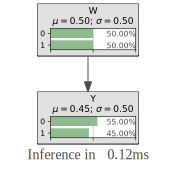

In [47]:
# @title Q4-inference-from-prior
gnb.showInference(party_net)

Calling `gnb.showInference()` like this, with just the Bayes Net object and no additional arguments, already tells us something we didn't know in advance!

Namely, it tells us that the **distribution of $Y$** when we **don't know anything about the weather $W$** demonstrates a slight preference for **staying in**: if we were taking bets on whether or not our conflicted partier was going to show up at the party, and we didn't know the weather outside, we'd be slightly better off (in expectation) betting on them **not showing up**.

However, the main focus of the Partier's Dilemma in Week 2 was the **"reverse" inference** that the PGM allows us to perform: the ability to take information about an **observed** variable (party attendance) and use this information to update our distribution over the values of a **latent** variable (the weather).

The implementation of this process in `PyAgrum` is super straightforward: you just need to supply one additional argument, `evs` (short for... evidences), to the `showInference()` function!

The value you give for `evs` should be a **Python dictionary** mapping the **name** of each observed RV to the **value** that was observed for it, where both the name and the value should be placed **in quotes**<sup>[1]</sup>, like:

```{.python}
gnb.showInference(party_net, evs={
    "X": "<observed value of X>",
    "Y": "<observed value of Y>",
    ...
})
```

To see this in action, the following code cell automatically **replicates** the result we computed manually in Week 2, that observing the potential-partier at the party increases the likelihood of Sunny weather from $0.5$ to (approx.) $0.89$:

---

<small>

1.  This is important to note here explicitly, because:

    * Though in **this** problem the inference will "just work" whether or not the values are placed in quotes,
    * This is only because `PyAgrum` keeps track of possible RV values using a **list**!
        * Here, the possible values for the RVs are stored in a list like `["0", "1"]`, meaning that the values just **happen to coincide with** Python's use of `0` to index the **first** element of a list and `1` to index the **second** element of a list!
    * As you'll see if you use unquoted values in the **dice** example below, this does **not** work as expected when the RV's support is **not** of the form `["0", "1", ...]`!
        * When we define a RV $Z$ to be the **sum of two dice rolls**, $Z$'s possible values are stored by `PyAgrum` as `["2", "3", "4", ..., "12"]`, meaning that the unquoted `0` will actually refer to $Z$ having the value `"2"`, unquoted `1` will refer to $Z$ having the value `"3"`, and so on...
    * Therefore, pls pls remember to place both the RV names as well as the observed **values** in quotes when using `showInference()`!

</small>

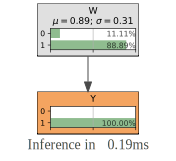

In [48]:
# @title Q4-inference-from-evidence
gnb.showInference(party_net, evs={
    "Y": "1"
})

Notice how the node for the RV $Y$ is now "shaded" in orange, to indicate that we're now visualizing a version of our PGM where we have **observed** the value of $Y$!

Now, use what you've learned through this quick intro to answer the following two questions. 

## [Question 4.1] The Counterfactual Posterior Distribution

Now say that we'd like to know what our distribution over the weather $W$ would be **if, counterfactually,** the partier **had not** shown up at the party. Use the `gnb.showInference()` function along with the `party_net` object to visualize the distribution over values of $W$ that we would obtain in this **counterfactual scenario**.

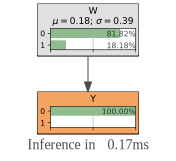

In [57]:
# @title Q4.1-response

# Your code here
gnb.showInference(party_net, evs={
    "Y": "0"
})

## [Question 4.2] Extending the Model

What should we do if we're not satisfied with the predictions made by our `party_net` PGM? While the intro-prob-stats course answer is often "go collect *more* data! Increase the sample size $n$!", in social science world you often may be better off collecting more *nuanced* or *disaggregated* data instead.

So, for this question, create a **new** `BayesNet` object called `super_party_net`, which you'll use to implement the following improved model:

1.  The weather RV $W$ can now take on **three** different values:
    * $W = 0$ now represents **snowy** weather,
    * $W = 1$ now represents **rainy** weather, and
    * $W = 2$ now represents **sunny** weather
2.  There is now an **additional** RV in the model, a binary RV $H$ representing whether the potential-partier has a **headache** or not:
    * $H = 0$ represents the potential-partier waking up **without** a headache, while
    * $H = 1$ represents the potential-partier waking up **with** a headache

Your model should assume **uniform priors** on $W$ and $H$, meaning that:

* $\Pr(W = w)$ should be $1/3$ for all $w \in \{0, 1, 2\}$ and
* $\Pr(H = h)$ should be $1/2$ for all $h \in \{0, 1\}$

Then, to model the eventual party-or-not outcome, your model should encode the following information:

* **Without** a headache, the potential-partier **goes to the party** with probability...
    * $0.15$ when it is **snowing**,
    * $0.30$ when it is **raining**, and
    * $0.90$ when it is **sunny**
* However, **waking up with a headache** decreases the probability in all three cases by exactly $0.1$
    * (So, for example, when it's **snowing**, the potential-partier goes to the party with probability $0.15$ if they don't have a headache, but this drops to $0.05$ when they do have a headache)
 
Create the new `super_party_net` in the following code cell, then use `gnb.showInference(super_party_net)` at the end to show the state of the resulting PGM before any information is observed (this is already provided for you, as the last line in the code cell)

BN{nodes: 3, arcs: 2, domainSize: 12, dim: 9, mem: 136o}


(pyagrum.BayesNet@0x62ca11b55660) BN{nodes: 3, arcs: 2, domainSize: 12, dim: 9, mem: 136o}

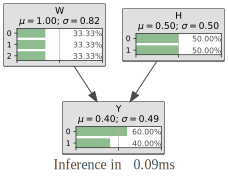

In [164]:
# @title Q4.2a-response
# Your code here, replace the None
super_party_net = gum.BayesNet()

# Your code here: add the appropriate nodes, edges, and CPTs
# Add three nodes - Weather (W), Headache (H) and Outcome (Y)
W_var = gum.RangeVariable("W", "Weather", 0, 2)
H_var = gum.RangeVariable("H", "Headache", 0, 1)
Y_var = gum.RangeVariable("Y", "Outcome", 0, 1)

# Add nodes to the net
super_party_net.add(W_var)
super_party_net.add(H_var)
super_party_net.add(Y_var)

# Add arcs to connect nodes
super_party_net.addArc("W", "Y")
super_party_net.addArc("H", "Y")

# Add CPTs
super_party_net.cpt("W").fillWith([1/3, 1/3, 1/3])  
super_party_net.cpt("H").fillWith([0.5,0.5])  
super_party_net.cpt("Y")[{'W': 0, "H": 0}] = [0.85, 0.15] # Probability going to the party if weather is snowing without headache
super_party_net.cpt("Y")[{'W': 0, "H": 1}] = [0.95, 0.05] # Probability going to the party if weather is snowing with headache
super_party_net.cpt("Y")[{'W': 1, "H": 0}] = [0.70, 0.30] # Probability going to the party if weather is rainy without headache
super_party_net.cpt("Y")[{'W': 1, "H": 1}] = [0.80, 0.20] # Probability going to the party if weather is rainy with headache
super_party_net.cpt("Y")[{'W': 2, "H": 0}] = [0.10, 0.90] # Probability going to the party if weather is summy without headache
super_party_net.cpt("Y")[{'W': 2, "H": 1}] = [0.20, 0.80] # Probability going to the party if weather is summy with headache
# Once the PGM is constructed, uncomment the following line to display the
# pre-evidence state of the net!
print(super_party_net)
display(super_party_net)
gnb.showInference(super_party_net)

Now, use this visualization to answer the following question:

As a **numeric value between 0 and 1** (i.e., **not** as a percentage), what is the probability that the potential-partier ends up going to the party, before we've observed any evidence?

In [159]:
# @title Q4.2b-response
q4_2b_response = 0.4 # Replace the None with a value between 0 and 1, inclusive

In [163]:
# @title Q4.2b-public-tests
q4_2b_public_tests = {
    'q4_2b_response defined': '✅ Passed!' if 'q4_2b_response' in globals() else "🔲 No variable named 'q4_2b_response' exists in Python memory",
    'Valid value': '✅ Passed!' if ('q4_2b_response' in globals()) and (q4_2b_response is not None) and (q4_2b_response >= 0.0) and (q4_2b_response <= 1.0) else "🔲 The value of q4_2b_response should be between 0 and 1, inclusive",
}
q4_2b_public_tests

{'q4_2b_response defined': '✅ Passed!',
 'Valid value': '🔲 The value of q4_2b_response should be between 0 and 1, inclusive'}

## Using the Extended Model

Now let's use the extended model to infer more precise estimates of the potential-partier's partying behavior! For each of the following four sub-questions, use `gnb.showInference()` to display the PGM with the given information incorporated, then use the resulting visualization to answer the question in the subsequent code cell.

## [Question 4.3] No Headache

Say we learn that the potential-partier has woken up **without** a headache. Use `gnb.showInference()` to visualize the state of the PGM after incorporating this information:

In [164]:
# @title Q4.3a-response

# Your code here
gnb.showInference(super_party_net, evs={'H': 0})

After incorporating this information, does the likelihood of attending the party...

* (a) Increase,
* (b) Decrease, or
* (c) Stay the same?

Record the (lowercase) letter for your response as the value for `q4_3b_response`:

In [171]:
# @title Q4.3b-response
q4_3b_response = "a" # Replace with "a", "b", or "c"

In [172]:
# @title Q4.3b-public-tests
q4_3b_public_tests = {
    'q4_3b_response defined': '✅ Passed!' if 'q4_3b_response' in globals() else "🔲 No variable named 'q4_3b_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q4_3b_response' in globals()) and (q4_3b_response in set('abc')) else "🔲 q4_3b_response should be a single lowercase letter between a and c",
}
q4_3b_public_tests

{'q4_3b_response defined': '✅ Passed!',
 'Valid response': '🔲 q4_3b_response should be a single lowercase letter between a and c'}

## [Question 4.4] Headache

For this question, assume we instead learn that the potential-partier **has** woken up with a headache. Use `gnb.showInference()` to visualize the state of the PGM after incorporating this information:

In [173]:
# @title Q4.4a-response

# Your code here
gnb.showInference(super_party_net, evs={"H": 1})

After incorporating this information, does the likelihood of attending the party...

* (a) Increase,
* (b) Decrease, or
* (c) Stay the same?

Record the (lowercase) letter for your response as the value for `q4_4b_response`:

In [175]:
# @title Q4.4b-response
q4_4b_response = "b" # Replace with "a", "b", or "c"

In [176]:
# @title Q4.4b-public-tests
q4_4b_public_tests = {
    'q4_4b_response defined': '✅ Passed!' if 'q4_4b_response' in globals() else "🔲 No variable named 'q4_4b_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q4_4b_response' in globals()) and (q4_4b_response in set('abc')) else "🔲 q4_4b_response should be a single lowercase letter between a and c",
}
q4_4b_public_tests

{'q4_4b_response defined': '✅ Passed!',
 'Valid response': '🔲 q4_4b_response should be a single lowercase letter between a and c'}

## [Question 4.5] Partying Without a Headache

In this and the next question, the goal is to use our fancier model to obtain **more precise** estimates of the weather, now that we have **two** signals we can use for our weather inference.

Here, as in the in-class example, assume that we **observe** that the potential-partier has in fact **attended** the party. We then go up and ask them how their head is feeling, and they report that they **do not** have a headache.

In the following code cell, use `gnb.showInference()` to visualize the state of the PGM after incorporating these **two** pieces of information (party attendance and lack of headache):

In [178]:
# @title Q4.5a-response

# Your code here
gnb.showInference(super_party_net, evs={"Y":1,  "H": 0})

After incorporating these two pieces of information, does the likelihood of **sunny weather**...

* (a) Increase,
* (b) Decrease, or
* (c) Stay the same?

Record the (lowercase) letter for your response as the value for `q4_5b_response`:

In [179]:
# @title Q4.5b-response
q4_5b_response = "a" # Replace with "a", "b", or "c"

In [180]:
# @title Q4.5b-public-tests
q4_5b_public_tests = {
    'q4_5b_response defined': '✅ Passed!' if 'q4_5b_response' in globals() else "🔲 No variable named 'q4_5b_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q4_5b_response' in globals()) and (q4_5b_response in set('abc')) else "🔲 q4_5b_response should be a single lowercase letter between a and c",
}
q4_5b_public_tests

{'q4_5b_response defined': '✅ Passed!',
 'Valid response': '🔲 q4_5b_response should be a single lowercase letter between a and c'}

## [Question 4.6] Partying With a Headache

Here, as in the in-class example, assume that we **observe** that the potential-partier has in fact **attended** the party. However, unlike in the previous question, this time we'd like to learn the **counterfactual** probabilities that our model would have produced **if** the attending-partier had instead reported that they **did** have a headache.

In the following code cell, use `gnb.showInference()` to visualize the state of the PGM after incorporating these **two** pieces of information (the factual party attendance, plus the counterfactual headache):

In [181]:
# @title Q4.6a-response

# Your code here
gnb.showInference(super_party_net, evs={"Y": 1, "H": 1})

After incorporating these two pieces of information (with one counterfactual), does the likelihood of **sunny weather**...

* (a) Increase,
* (b) Decrease, or
* (c) Stay the same?

Record the (lowercase) letter for your response as the value for `q4_6b_response`:

In [ ]:
# @title Q4.6b-response
q4_6b_response = "a" # Replace with "a", "b", or "c"

In [182]:
# @title Q4.6b-public-tests
q4_6b_public_tests = {
    'q4_6b_response defined': '✅ Passed!' if 'q4_6b_response' in globals() else "🔲 No variable named 'q4_6b_response' exists in Python memory",
    'Valid response': '✅ Passed!' if ('q4_6b_response' in globals()) and (q4_6b_response in set('abc')) else "🔲 q4_6b_response should be a single lowercase letter between a and c",
}
q4_6b_public_tests

{'q4_6b_response defined': "🔲 No variable named 'q4_6b_response' exists in Python memory",
 'Valid response': '🔲 q4_6b_response should be a single lowercase letter between a and c'}

# [Part 5] PGM Warmup II: Aggregators

At first, both the tutorial and the main questions in this part may seem roughly similar to those in the previous part (meaning, you'll wonder why there's a whole separate part for this...)

However, the key difference between the models in the last part and the models in this part is that we're now going to take advantage of the fact that **Random Variables were "added" to probability theory (on top of just events) to enable us to *do math* (addition, multiplication, division, integration, and so on) with unknown quantities!**

So, whereas in Part 4 we used `PyAgrum` to see how the observation of "pure" **events** (or their negations) cascaded through a PGM, here we'll examine a new type of **non-random variable**, called an **aggregator**, that we can use to make our PGMs **compute** things with the RVs we add.

To see why this ability to compute with RVs is crucial for probabilistic modeling in the social sciences, consider **linear regression**, the "workhorse" model at the core of e.g. econometrics. A linear regression model is built around constructing a predictor $\widehat{y}$ of the **dependent** variable $Y$ as a linear function of $p$ **independent** variables $X_i$, with functional form:

$$
\widehat{y} = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p
$$

If we want the ability to use this model in the **probabilistic** setting that is often more appropriate for social science (for reasons we discussed in Weeks 1 and 2)...

* We'll first need to represent the indpendent variables $X_i$ as RVs, which we already know how to do from the previous question, but then
* We'll **also** need a way to represent the fact that $\widehat{y}$, though it may "start" as a RV in a sense (when we have not observed all $X_i$ values), becomes a deterministic function of $X_1$ through $X_p$: its value is determined once we've observed values for all features.

So, to build our way towards this full-on computational ability (which we'll implement in `PyMC`), the following tutorial walks you through constructing a PGM to represent the **sum(!)** of two dice rolls, then the subsequent questions ask you to construct your own PGM to represent two different aggregation functions of three coin flips.

## Quicker Tutorial: Dice Spice (Oh You Thought I Was Rollin You?)

Thankfully, I don't have to be as pedantic in this tutorial, since everything is *mostly* the same as the previous tutorial, **except for one line**, where we use `PyAgrum`'s `addSUM()` function, rather than the `add()` function we used in the previous part, to indicate that we're adding a special kind of node...

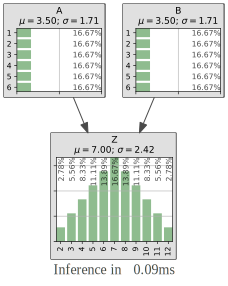

In [107]:
# @title Q5-construct-pgm
dice_net = gum.BayesNet()
dice_net.add(gum.RangeVariable("A", "Die A", 1, 6))
dice_net.add(gum.RangeVariable("B", "Die B", 1, 6))

# The key difference: here we use addSUM() rather than add(). Notice how we
# need to define the *support* of Z here: when we move to PyMC, we'll be able
# to handle even more complicated cases where we may not know in advance the
# exact range of values the RV can take on!
dice_net.addSUM(gum.RangeVariable("Z", "Sum of Rolls", 2, 12))

dice_net.addArc("A", "Z")
dice_net.addArc("B", "Z")
dice_net.cpt("A").fillWith([1/6 for _ in range(1, 6+1)])
dice_net.cpt("B").fillWith([1/6 for _ in range(1, 6+1)])
gnb.showInference(dice_net)

Then, as long as we've implemented the right aggregator for what we'd like $Z$ to represent, we can use `gnb.showInference()` as before! Here, we condition on the **sum** of the two rolled die being **11**, and obtain a **posterior** distribution over the possible values of the individual rolls that could have produced this aggregate value:

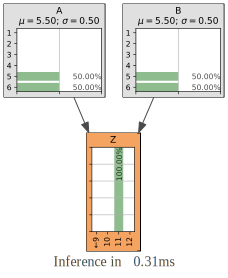

In [108]:
# @title Q5-infer
gnb.showInference(dice_net, evs={"Z": "11"})

Now that you know how to implement **aggregators** in `PyAgrum`, the following questions ask you to construct a **coin-flipping** PGM, to carry out the same kind of conditional three-coins analysis as in the beginning of [this chapter](http://probmods.org/chapters/conditioning.html) of the *Probabilistic Modeling* online textbook!

## [Question 5.1] Constructing the Three-Coins PGM

First, using what you learned from the above tutorial, construct a `BayesNet` object named `coin_net` which implements the necessary nodes, edges, and CPTs to represent the three-coin example from the beginning of the *Probabilistic Modeling* chapter.

Once the PGM is completed, use `gnb.showInference(coin_net)` to display the state of the model before observing any information.

As a hint, this no-information state visualization should look as follows:

<img src='https://raw.githubusercontent.com/jpowerj/dsan-content/5773c3043c5c1ef886a7f593d5d8e44733ca9432/2025-sum-dsan5650/hw1/three_coins.svg' />

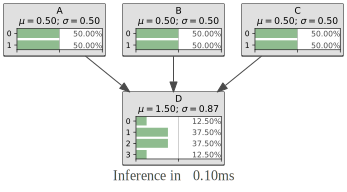

In [166]:
# @title Q5.1-response
# Your code here
coin_net = gum.BayesNet()

# Your code here (add the appropriate nodes, edges, and CPTs)
coin_net.add(gum.RangeVariable("A", "Coin A", 0, 1))
coin_net.add(gum.RangeVariable("B", "Coin B", 0, 1))
coin_net.add(gum.RangeVariable("C", "Coin C", 0, 1))
coin_net.addSUM(gum.RangeVariable("D", "Sum of Flips", 0, 3))

coin_net.addArc("A", "D")
coin_net.addArc("B", "D")
coin_net.addArc("C", "D")

coin_net.cpt("A").fillWith([0.5, 0.5])
coin_net.cpt("B").fillWith([0.5, 0.5])
coin_net.cpt("C").fillWith([0.5, 0.5])

# Once you've completed the construction, uncomment the following line to visualize the resulting PGM

gnb.showInference(coin_net)

## [Question 5.2] Exactly Three Heads

For this question, assume that we've **observed** that the total number of Heads is 3. Use the `gnb.showInference()` function with appropriate arguments to visualize the state of the PGM after incorporating this information.

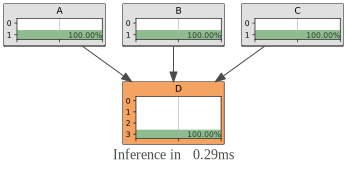

In [167]:
# @title Q5.2-response

# Your code here
gnb.showInference(coin_net, evs = {"D": 3})

## [Question 5.3] Exactly Two Heads

This time, assume that we've **obsered** that the total number of Heads across all three coin flips is 2. Use the `gnb.showInference()` function with appropriate arguments to visualize the state of the PGM after incorporating this information.

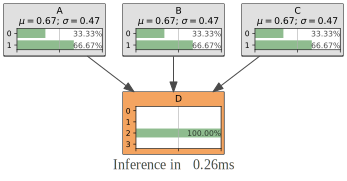

In [168]:
# @title Q5.3-response

# Your code here
gnb.showInference(coin_net, evs = {"D": 2})

## [Question 5.4] At Least Two Heads

You would think that this question would "flow" nicely as just a third use of `gnb.showInference()` on `coin_net`... but you'd be wrong 😭

For reasons that are somewhat hard to explain without diving more deeply into the inner-workings of the **inference algorithms** underlying `PyAgrum` and `PyMC` (and any other PGM library or Probabilistic Programming Language), it turns out that Bayesian inference goes from easy to capital-H Hard when we start to introduce non-"smooth" control-flow operations into our DGPs like `or`, `not`, and `if`.

As a result of these scary under-the-hood details, sadly but truly you will sometimes need to essentially "trick" the modeling library or PPL into estimating these harder functions by using the functions that are available to you in non-standard ways. This question is here to give you practice with these kinds of "tricks".

Specifically, we want to be able to use `PyAgrum` to incorporate the event that *"the total number of Heads across all three coin flips is greater than or equal to 2"**. However, to do this, you'll need to implement a **new PGM** called `tricky_coin_net`. Use the following two hints to get started:

* Hint 1: You can copy-and-paste the code you used to construct `coin_net` into the following code cell: there's only one line you'll need to change in the above code to construct `tricky_coin_net`
* Hint 2: There is a function in `PyAgrum` that starts with `add`, and is listed on [this page](https://pyagrum.readthedocs.io/en/2.1.1/BNModel.html#pyagrum.BayesNet), which you can use to "trick" `PyAgrum`'s inference engine into aggregating the RVs $A$, $B$, and $C$ into $D$ in such a way that you can use the resulting value of $D$ to "encode" whether or not the sum of the three coin flips was **greater than or equal to 2** or **less than 2**...

Use these two hints to implement `tricky_coin_net` in the following code cell:

In [169]:
# @title Q5.4a-response

# Your code here
tricky_coin_net = gum.BayesNet()

# Your code here (add the appropriate nodes, edges, and CPTs)
tricky_coin_net.add(gum.RangeVariable("A", "Coin A", 0, 1))
tricky_coin_net.add(gum.RangeVariable("B", "Coin B", 0, 1))
tricky_coin_net.add(gum.RangeVariable("C", "Coin C", 0, 1))

tricky_coin_net.addAND(gum.RangeVariable("AB", "Sum of A and B", 0, 1))
tricky_coin_net.addAND(gum.RangeVariable("AC", "Sum of A and C", 0, 1))
tricky_coin_net.addAND(gum.RangeVariable("BC", "Sum of B and C", 0, 1))

tricky_coin_net.addOR(gum.RangeVariable("D", "At least 2 heads", 0, 1))

tricky_coin_net.addArc("A", "AB")
tricky_coin_net.addArc("B", "AB")
tricky_coin_net.addArc("A", "AC")
tricky_coin_net.addArc("C", "AC")
tricky_coin_net.addArc("B", "BC")
tricky_coin_net.addArc("C", "BC")
tricky_coin_net.addArc("AB", "D")
tricky_coin_net.addArc("AC", "D")
tricky_coin_net.addArc("BC", "D")

tricky_coin_net.cpt("A").fillWith([0.5 , 0.5])
tricky_coin_net.cpt("B").fillWith([0.5 , 0.5])
tricky_coin_net.cpt("C").fillWith([0.5 , 0.5])

tricky_coin_net

(pyagrum.BayesNet@0x62ca119cf9e0) BN{nodes: 7, arcs: 9, domainSize: 128, dim: 23, mem: 48o}

Once you're satisfied with your construction of `tricky_coin_net`, use `gnb.showInference()` with the appropriate `evs` argument in the following code cell to visualize the distributions of $A$, $B$, and $C$ after **incorporating the evidence** that the total number of Heads was **greater than or equal to 2**.

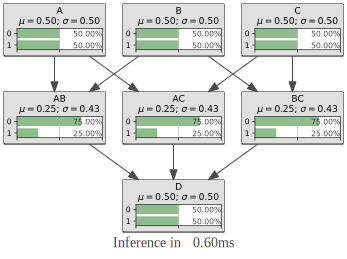

In [170]:
# @title Q5.4b-response

# Your code here
gnb.showInference(tricky_coin_net)

Finally, using the information contained in the post-update PGM visualization you just generated, answer the following question (by replacing the `None` value in the subsequent code cell):

* After incorporating the information that the total number of Heads was **greater than or equal to 2**, what is the **likelihood that coin $A$ came up Heads?**

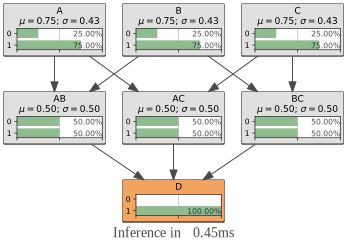

In [171]:
# @title Q5.4c-response
gnb.showInference(tricky_coin_net, evs = {"D": 1})
q5_4c_response = 0.75 # Replace with a numeric value between 0 and 1, inclusive

In [197]:
# @title Q5.4c-public-tests
q5_4c_public_tests = {
    'q5_4c_response defined': '✅ Passed!' if 'q5_4c_response' in globals() else "🔲 No variable named 'q5_4c_response' exists in Python memory",
}
q5_4c_public_tests

{'q5_4c_response defined': '✅ Passed!'}